### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [2]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


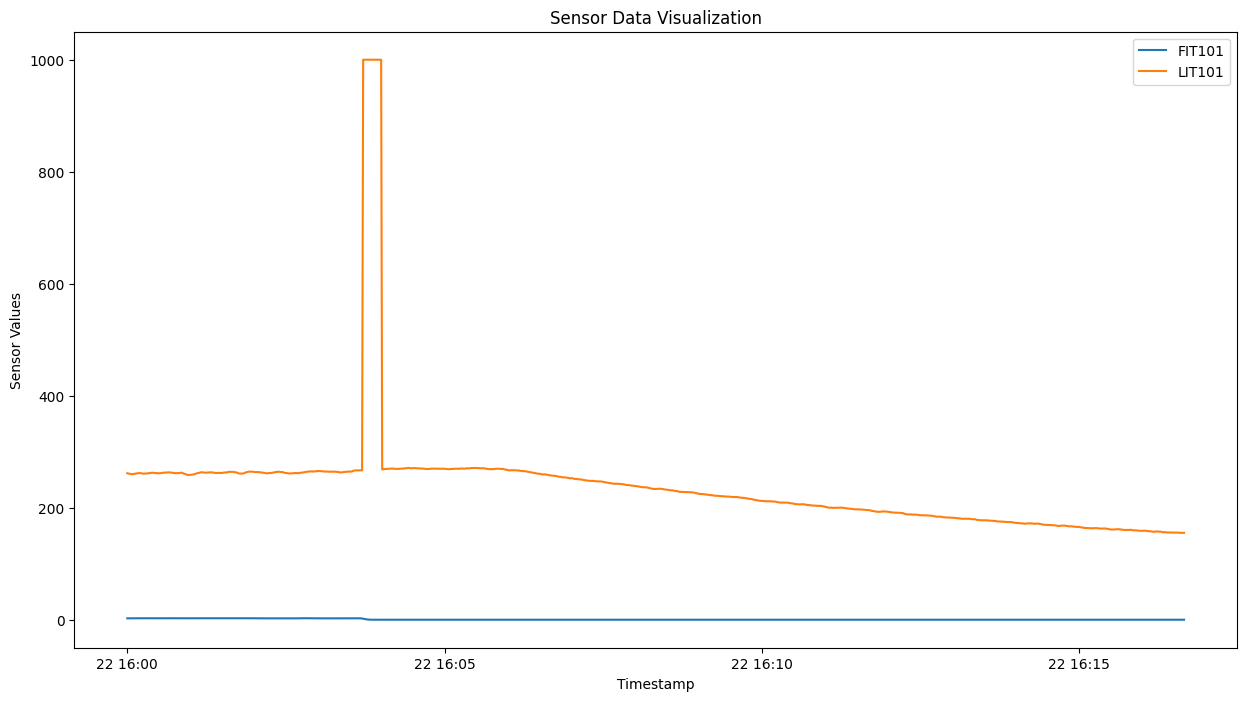

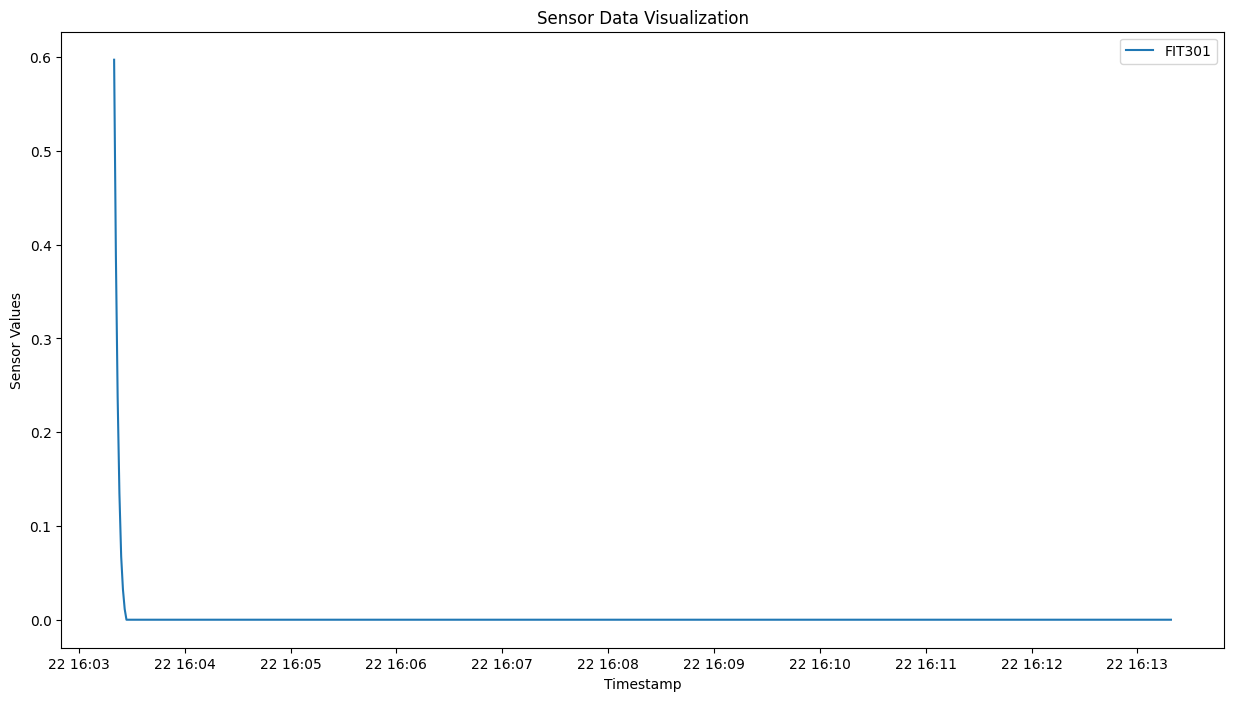

/Users/flyersmacpro/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


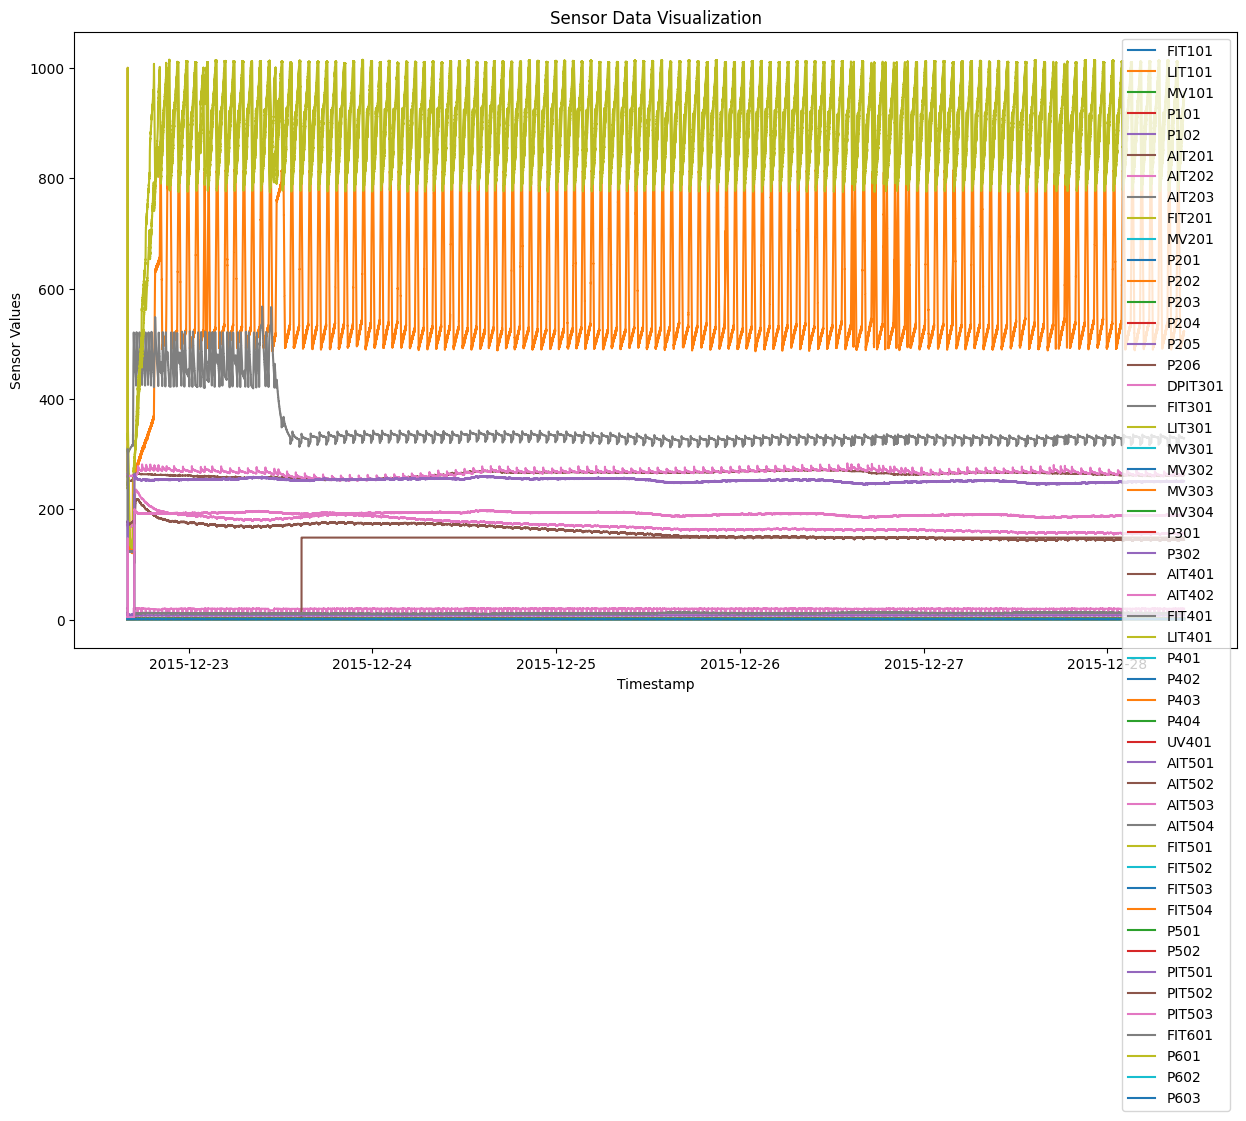

In [3]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)
#visualize_sensor_data(test_data)

# Familiarization

1. Based on the given plots, we can identify multiple types of signals received by the sensors. The first plot shows a mixed signal type for LIT101, since it presents a short peak just before 22 16:05 (event-driven) but then has a steady downward trend. The other type found in this plot is a steady/constant type for FIT101 since it barely moves and keeps a constant value of around 0. In the second plot. FIT301 is a mixed signal type, but predominantly a constant one as after 22 16:04 it keeps a constnt value of 0. The third plot contains multiple types. One of the types is periodic/oscillatory (e.g. orange signal oscillating around 600), even though they mostly are mixed, the preodminant part is a periodic one. Also, there seems to be a step-change signal, going from zero to around 170. We also can see noisy signals (pink ones around the baseline) that jitter around the baseline of 0.
2. The third plot shows us a few signs that some of the signals might be correlated. For example, the green-ish and orange signals seem to be positively correlated since they rise at the same time and seem to have similar peaks. Another example is the pair of pink and brown-ish signals that start just above 200. They also seem to be positively correlated since they go up and down at the same time. The first mentioned pair does indeed show cyclic behavior (they are also both periodic/oscillatory signals).


## PCA-Based anomaly detection

First, we have to check which k we need in order to run PCA. But before that, we should have our PCA implemented.

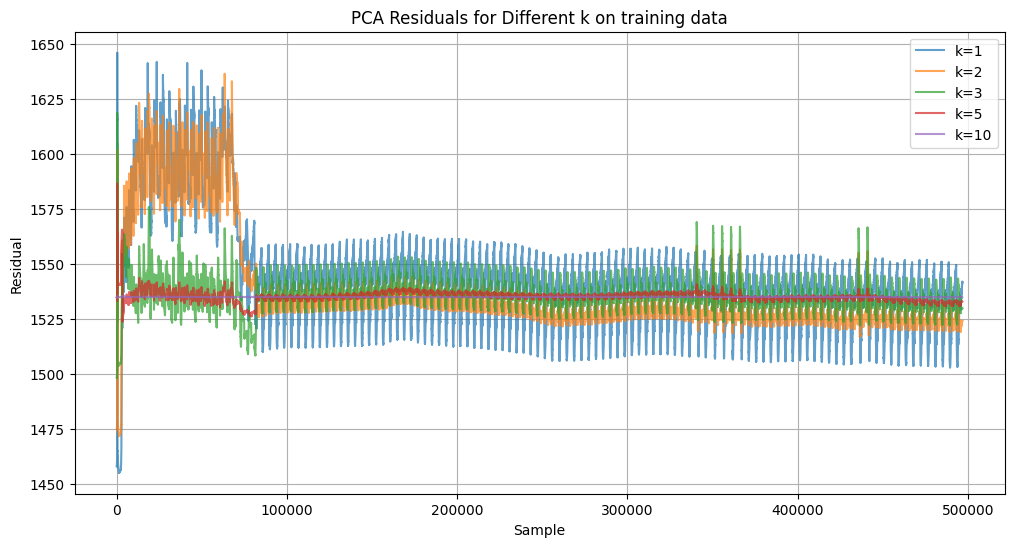

In [4]:
def principal_component_analysis(df, k):
    eigenvectors = np.zeros(shape=(df.shape[1], k))

    data = df.values
    centered_data = data - np.mean(data, axis=0)
    covariance_matrix = np.cov(centered_data, rowvar=False, bias=True)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, indices[:k]]

    return eigenvectors

def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))

    data = df.values
    centered_data = data - np.mean(data, axis=0)
    projected_data = np.dot(centered_data, eigenvectors)

    return pd.DataFrame(projected_data)

def reconstruct_from_pca(projected_df, eigenvectors):
    projected = projected_df.values
    reconstructed = np.dot(projected, eigenvectors.T)
    return pd.DataFrame(reconstructed)

train_data_numeric = train_data.select_dtypes(include=[np.number])

k_vals  = [1, 2, 3, 5, 10]
plt.figure(figsize=(12,6))

for k in k_vals:
    eigen = principal_component_analysis(train_data_numeric, k)
    proj = apply_principal_component_analysis(train_data_numeric, eigen)
    recon = reconstruct_from_pca(proj, eigen)
    residuals = np.linalg.norm(train_data_numeric.values - recon.values, axis=1)

    plt.plot(residuals, label=f'k={k}', alpha=0.7)

plt.title("PCA Residuals for Different k on training data")
plt.xlabel("Sample")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.show()

As we can see from the plot, for k = 2 we keep most of the information and get rid of outliers (less sporadic peaks). For k = 1, we can observe that the information looks almost the same, but we have a lot of higher peaks and noise, meaning important variance is lost. For the values larger than 2, we gain very little information since the residuals decrease slightly and appear almost constant, although we have high variance. Thus k = 2 captures the overall structure and represents a good trade-off between reconstruction accuracy and anomaly sensitivity (between variance and information gain).

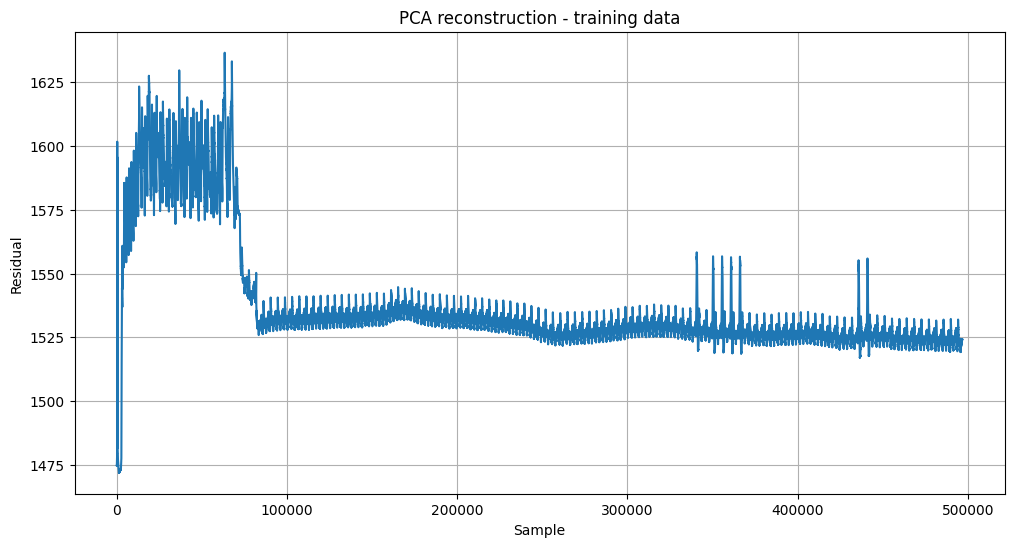

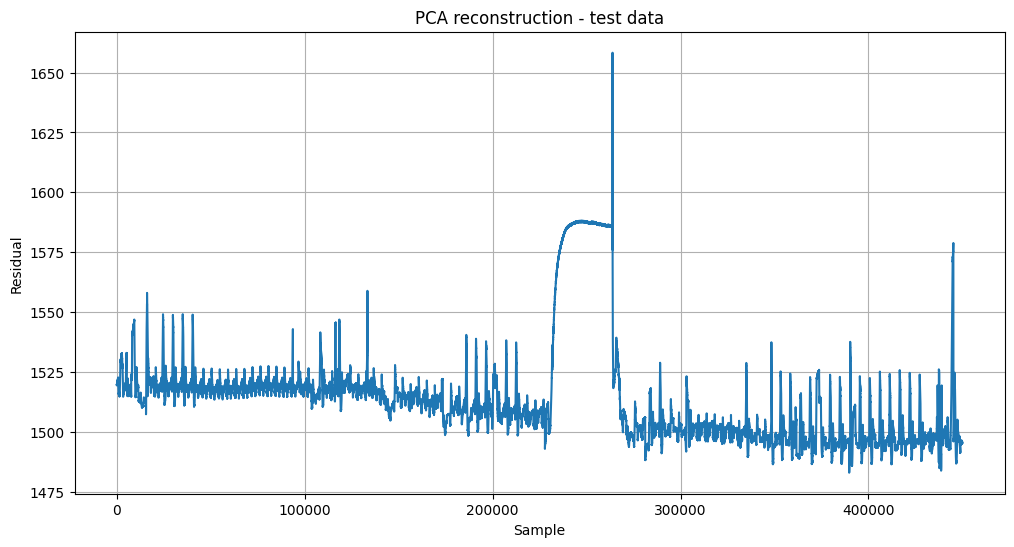

In [5]:
k = 2
eigen = principal_component_analysis(train_data_numeric, k)
train_proj = apply_principal_component_analysis(train_data_numeric, eigen)

test_data_numeric = test_data.select_dtypes(include=[np.number])

test_proj = apply_principal_component_analysis(test_data_numeric, eigen)

train_recon = reconstruct_from_pca(train_proj, eigen)
test_recon = reconstruct_from_pca(test_proj, eigen)

train_residuals = np.linalg.norm(train_data_numeric.values - train_recon.values, axis=1)
test_residuals = np.linalg.norm(test_data_numeric.values - test_recon.values, axis=1)

plt.figure(figsize=(12,6))
plt.plot(train_residuals)
plt.title("PCA reconstruction - training data")
plt.xlabel("Sample")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_residuals)
plt.title("PCA reconstruction - test data")
plt.xlabel("Sample")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

We can also then use a threshold to find anomalies. Setting a threshold to mean+3*std, the points that are above this threshold are very likely to be anomalies. We use this thershold because it is a very common one, referred to as the "three-sigma rule" or empirical rule.

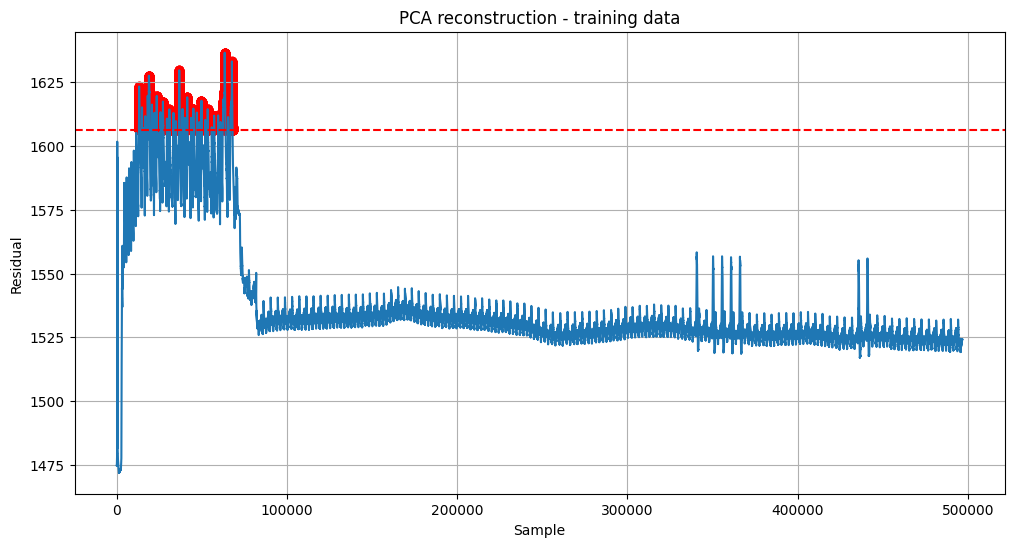

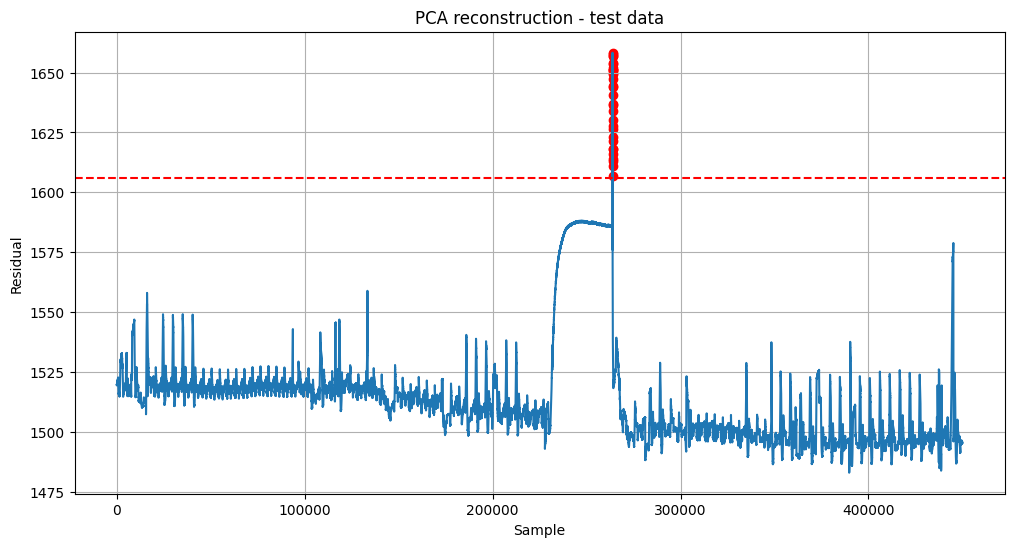

In [6]:
threshold = train_residuals.mean() + 3 * train_residuals.std()

#threshold on train
anomalies_train = np.where(train_residuals > threshold)[0]
plt.figure(figsize=(12,6))

plt.plot(train_residuals, label="Residuals")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold (mean+3*σ)")

plt.scatter(anomalies_train, train_residuals[anomalies_train], color="red", label="Anomalies")

plt.title("PCA reconstruction - training data")
plt.xlabel("Sample")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

#threshold on test
anomalies_test = np.where(test_residuals > threshold)[0]
plt.figure(figsize=(12,6))

plt.plot(test_residuals, label="Residuals")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold (mean+3*σ)")

plt.scatter(anomalies_test, test_residuals[anomalies_test], color="red", label="Anomalies") 

plt.title("PCA reconstruction - test data")
plt.xlabel("Sample")
plt.ylabel("Residual")
plt.grid(True)
plt.show()

**Do you see large abonormalities in the training data?**

Based on our threshold, the points highlited in red in the plot above are indeed high since they represent very rare occurences. Since we are using a one-sided test, this is equivalent to a 0.13% probability of a point exceeding the threshold so these points are indeed unsual.

**Can you explain why these occur?**

Large abnormalities such as the ones pointed out in the previous question can happen due to multiple reasons:
- The training data may contain true abnormalities (spikes, glitches)
- Some features may have incorrect scaling
- Some signals may be non-stationary (their statistical properties change over time; e.g. a machine slowly drifting out of allignment, sensor being affected by the temperature cycle in a day)
- Some signals may be transient (they have a short-lived or temporary change in their signal; e.g. a sudden voltage spike, a peak in network traffic)

**Describe the kind of anomalies you expect to detect using PCA**

We expect that PCA can detect the following types of anomalies:
- Point anomalies (isolated spikes)
- Short bursts
- Sensor failures that produce uncorrelated noise

## DTW-Based Anomaly Detection

Now let's move on to Dynamic Time Warping based anomaly detection. 

First, we include the implementation of the Dynamic Time Warping distance function. This function computes the optimal alignment path between two sequences, allowing for non-linear mapping of time. This is crucial for our analysis because SCADA signals often exhibit cyclic behaviour where the exact speed or phase of the cycle might vary slightly, rendering standard Euclidean distance ineffective.

In [39]:
def dynamic_time_warping(a, b):
    n = a.size
    m = b.size

    dtw_distance = np.inf

    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = (a[i-1] - b[j-1]) ** 2
            dtw_matrix[i, j] = cost + min(
                dtw_matrix[i-1, j],
                dtw_matrix[i, j-1],
                dtw_matrix[i-1, j-1]
            )
    
    dtw_distance = float(np.sqrt(dtw_matrix[n, m]))

    return dtw_distance

For this analysis, we selected the signal LIT101. In the data familiarisation phase, this signal displayed clear cyclic and continuous behaviour, making it an ideal candidate for DTW, which excels at detecting shape-based anomalies in periodic data.

DTW is a computationally expensive algorithm with a time complexity of O(n^2). Running the algorithm on the full dataset would result in an infeasibly long runtime for this lab environment. To balance performance withe execution time, we define a SUBSET_SIZE of 3000 (We've tried with other sizes as well). This allows us to demonstrate the efficacy of the detection pipeline without excessive wait times.

To capture the temporal context, we turn the continuous signal into discrete sequences using a sliding window approach. The get_sliding_windows function below implements this.

In [40]:
target_signal_name = 'LIT101'

SUBSET_SIZE = 3000

train_signal = train_data[target_signal_name].values[:SUBSET_SIZE]
test_signal = test_data[target_signal_name].values[:SUBSET_SIZE]

def get_sliding_windows(signal, window_size, stride):
    windows = []
    for i in range(0, len(signal) - window_size + 1, stride):
        window = signal[i : i + window_size]
        windows.append(window)

    return np.array(windows)

We defined the following parameters for the sliding window approach, after "trial and error" with the runtime:
- WINDOW_SIZE = 15.
- STRIDE_TRAIN = 8.
- STRIDE_TEST = 5.

The code below generates these window sets and then iterates through every test window. For each test window, it computes the DTW distance to all representative training windows and stores the minimum distance as the residual. A high residual indicates that the test window's shape does not match any known normal pattern.

In [41]:
WINDOW_SIZE = 15
STRIDE_TRAIN = 8
STRIDE_TEST = 5

representatives = get_sliding_windows(train_signal, WINDOW_SIZE, STRIDE_TRAIN)
print(f"Training patterns (representatives): {len(representatives)}")

test_windows = get_sliding_windows(test_signal, WINDOW_SIZE, STRIDE_TEST)
print(f"Test windows to analyse: {len(test_windows)}")

dtw_residuals = []
print("Starting DTW comparison")

for i, t_window in enumerate(test_windows):
    min_dist = float('inf')

    for rep_window in representatives:
        dist = dynamic_time_warping(t_window, rep_window)
        if (dist < min_dist):
            min_dist = dist
    
    dtw_residuals.append(min_dist)

dtw_residuals = np.array(dtw_residuals)
print("\nDone computing residuals.")

Training patterns (representatives): 374
Test windows to analyse: 598
Starting DTW comparison

Done computing residuals.


We visualise the computed DTW residuals for the test set. The residual represents the dissimilarity between a test window and its closest match in the training "normal" library. 

Thesholding strategy: In this step, we define the anomaly threshold using the 95th percentile of the residuals. This guarantees that 5% of the data will be flagged, which can be useful for ranking the "top-N" most likely anomalies, but might generate false positives if the system is very stable.

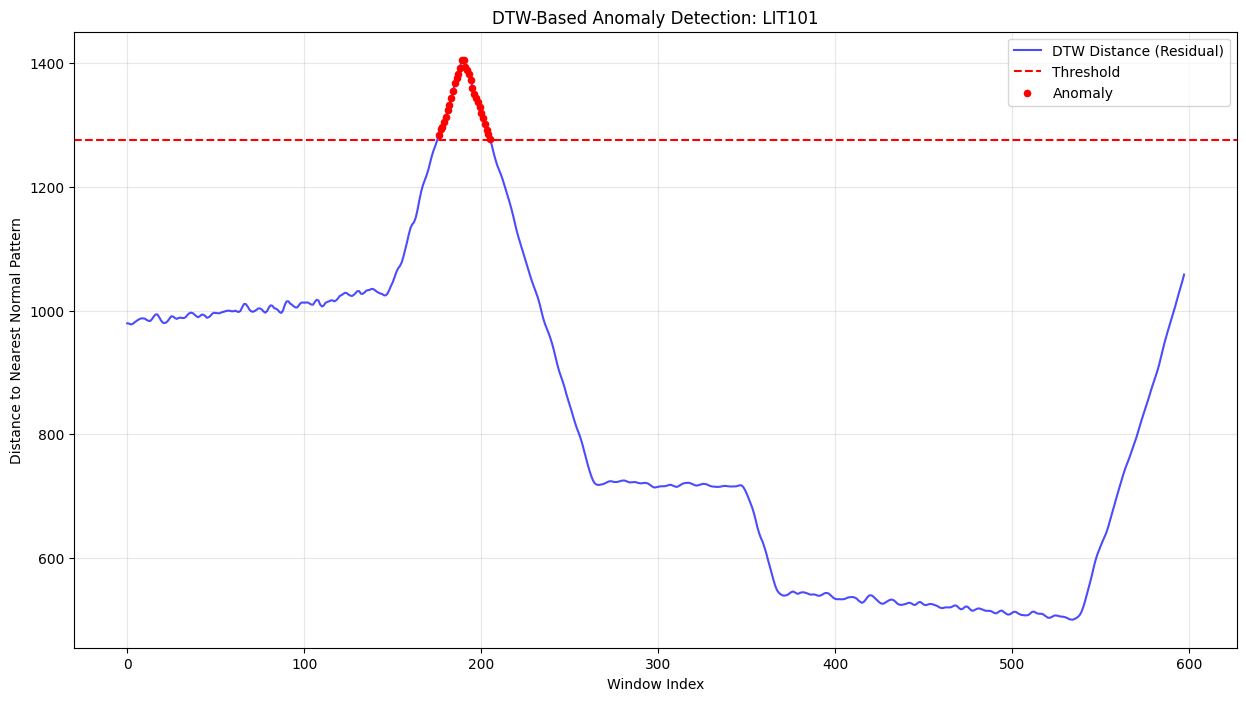

Detected 30 anomalies in the subset.


In [42]:
plt.figure(figsize=(15, 8))

plt.plot(dtw_residuals, label='DTW Distance (Residual)', color='blue', alpha=0.7)

threshold = np.percentile(dtw_residuals, 95)
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')

anomalies_idx = np.where(dtw_residuals > threshold)[0]
plt.scatter(anomalies_idx, dtw_residuals[anomalies_idx], color='red', s=20, label='Anomaly', zorder=5)

plt.title(f"DTW-Based Anomaly Detection: {target_signal_name}")
plt.xlabel("Window Index")
plt.ylabel("Distance to Nearest Normal Pattern")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Detected {len(anomalies_idx)} anomalies in the subset.")

This DTW residual plot for signal LIT101 reveals a distinct anomaly around window indices 160-220. This appears as a sharp triangular spike in the distance to the nearest normal pattern, indicating a large temporal deviation from normal behaviour. DTW is highly effective at capturing such shape-based anomalies. After the anomaly, the system transitions into a new but stable operating regime, reflected by a lower residual plateau. Toward the end of the sequence another gradual rise occurs, suggesting another regime shift but not severe enough to be considered anomalous. 

This analysis demonstrates how DTW distances can detect process anomalies based on temporal dynamics rather than absolute values like in PCA. These 30 anomalies likely represent periods where the cyclic process was interrupted or shifted in frequency - types of errors that point-based methods like PCA might miss if the values remain within normal bounds.